In [3]:
print("hello world")

hello world


In [83]:
import pandas as pd
data_path = '../data/skylab_instagram_datathon_dataset.csv'

data = pd.read_csv(data_path, delimiter=';')  # Specify the delimiter (e.g., comma)

In [84]:
# Assuming 'data' is your DataFrame and 'metrics' is a list of columns to interpolate
def clean_dataframe(data, metrics, method: str="linear"):
    data = data.sort_values("period_end_date")
    companies = list(data["business_entity_doing_business_as_name"].unique())
    companies = [name for name in companies if name != "All Brands"]
    new = [None]*len(companies) 
    # Group by the company name and apply interpolation within each group
    for i in range(len(companies)):
        company = companies[i]
        company_idx = (data["business_entity_doing_business_as_name"] == company)
        filtered = data[company_idx]
        filtered[metrics] = filtered[metrics].interpolate(method=method)
        filtered = filtered.dropna(subset=metrics)
        new[i] = filtered

    new_data = pd.concat(new, ignore_index=True)
    return new_data.sort_values("period_end_date")

data["period_end_date"] = pd.to_datetime(data["period_end_date"])

metrics = ["followers", "pictures", "likes", "videos", "comments"]
data = clean_dataframe(data, metrics)

/var/folders/gd/8zhrd5vs3l9gbslf3h97mk_h0000gn/T/ipykernel_15593/2689017618.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered[metrics] = filtered[metrics].interpolate(method=method)
/var/folders/gd/8zhrd5vs3l9gbslf3h97mk_h0000gn/T/ipykernel_15593/2689017618.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered[metrics] = filtered[metrics].interpolate(method=method)
/var/folders/gd/8zhrd5vs3l9gbslf3h97mk_h0000gn/T/ipykernel_15593/2689017618.py:12: SettingWithCopyWarning: 
A value is tryin

In [85]:
#Sort the data by company name and period end date
impute_test = data.sort_values(by=['business_entity_doing_business_as_name', 'period_end_date'])

features = ['followers_delta', 'followers_second_delta',
       'followers_spike', 'average_engagement_per_post',
       'like_to_comment_ratio', 'per_post_aquisition', 'engagement_rate',
       'relative_growth', 'growth_per_post',
       'growth_per_engagement', 'video_by_followers', 'picture_by_followers',
       'picture_virality_index', 'video_virality_index', "virality_index"]

# Group the data by company name
grouped = impute_test.groupby('business_entity_doing_business_as_name')

# For each company, process the data to handle duplicates and compset variations
company_tables = {}
for name, group in grouped:
    # Drop the company name column as it's redundant in individual company dataframes
    group = group.drop(columns='business_entity_doing_business_as_name')
    group.drop_duplicates()
    
    # Group by period_end_date and aggregate
    group = group.groupby('period_end_date').agg({
        'compset_group': lambda x: list(set(x))[0],
        'compset': lambda x: list(set(x)),  # Convert compset values to a set to remove duplicates, then to a list
        'followers': 'mean',  # Assuming followers should be averaged
        'pictures': 'sum',  # Summing up the pictures
        'videos': 'sum',    # Summing up the videos
        'comments': 'sum',  # Summing up the comments
        'likes': 'sum'      # Summing up the likes
    }).reset_index()

    # Store the processed DataFrame back to the company_tables dictionary
    company_tables[name] = group


# Iterate over each company in the company_tables
for company, df in company_tables.items():
    # Ensure the data is sorted by date - assuming 'period_end_date' is the weekly identifier
    df = df.sort_values(by='period_end_date')

    # Group by 'period_end_date' to handle data week by week
    weekly_data = df.groupby('period_end_date').agg({
        'likes': 'sum',
        'comments': 'sum',
        'followers': 'mean',  # Assuming 'followers' is stable across the week, we take the mean
        'pictures': 'sum',    # Summing up the number of pictures
        'videos': 'sum'       # Summing up the number of videos
    }).reset_index()

    weekly_data["followers_delta"] = weekly_data["followers"].diff().fillna(0)
    weekly_data["followers_second_delta"] = weekly_data["followers_delta"].diff().fillna(0)

    weekly_data["followers_spike"] = ((weekly_data["followers_delta"] - weekly_data["followers_delta"].median()).abs() > weekly_data["followers_delta"].std()).astype(int)

    # Calculate the average engagement per post for the baseline
    weekly_data['average_engagement_per_post'] = (weekly_data['likes'] + weekly_data['comments']) / (weekly_data['pictures'] + weekly_data['videos'] + 0.001)

    # Calculate like to comment ratio
    weekly_data['like_to_comment_ratio'] = (weekly_data['likes'] / (weekly_data['comments'] + 0.001))

    # Calculate per post aquisition
    weekly_data['per_post_aquisition'] = weekly_data["followers_delta"] / (weekly_data['likes'] + weekly_data['comments'] + 0.001)

    # Calculate the engagement rate for each week
    weekly_data['engagement_rate'] = (weekly_data['likes'] + weekly_data['comments']) / (weekly_data['followers'] + 0.001)
    weekly_data['picture_engagement'] = (weekly_data['pictures']) / (weekly_data['followers'] + 0.001)
    weekly_data['video_engagement'] = (weekly_data['videos']) / (weekly_data['followers'] + 0.001)

    # Calculate the average likes and comments per post for each week
    weekly_data['average_likes_per_post'] = weekly_data['likes'] / (weekly_data['pictures'] + weekly_data['videos'] + 0.001)
    weekly_data['average_comments_per_post'] = weekly_data['comments'] / (weekly_data['pictures'] + weekly_data['videos'] + 0.001)

    # Calculate growth coefficients 
    weekly_data['relative_growth'] = weekly_data['followers_delta']/(weekly_data['followers'] + 0.001)
    weekly_data['growth_per_post'] = (weekly_data['relative_growth'])/(weekly_data['pictures'] + weekly_data['videos'] + 0.001)
    weekly_data['growth_per_engagement'] = (weekly_data['relative_growth'])/(weekly_data['likes'] + weekly_data['comments']+0.001)

    #calculate virality coefficients
    weekly_data['video_by_followers'] = (weekly_data['videos']/(weekly_data['followers'] + 0.001))
    weekly_data['picture_by_followers'] = (weekly_data['pictures']/(weekly_data['followers'] + 0.001))
    weekly_data['picture_virality_index'] = weekly_data['picture_engagement']*weekly_data['relative_growth']
    weekly_data['video_virality_index'] = weekly_data['video_engagement']*weekly_data['relative_growth']
    weekly_data["virality_index"] = weekly_data['picture_virality_index'] + weekly_data['video_virality_index']
    

    # Calculate the like-to-comment ratio for each week
    # I actually think this feature does not make sense
    #weekly_data['like_to_comment_ratio'] = weekly_data['likes'] / (weekly_data['comments'] + 0.001)

    # Calculate the virality rate for each week
    # Virality rate = (engagement per post this week / average engagement per post baseline) * 100
    # weekly_data['virality_rate'] = (weekly_data['average_engagement_per_post'] / weekly_data['average_engagement_per_post'].mean()) * 100
    
    # Merge the calculated weekly metrics back to the original dataframe
    df = pd.merge(df, weekly_data[['period_end_date'] + features], on='period_end_date', how='left')
    df["business_entity_doing_business_as_name"] = [company]*len(df)
    
    # Update the company_tables dictionary with the modified DataFrame
    company_tables[company] = df

In [33]:
import pandas as pd

# Assuming 'all_data' is your DataFrame and it includes 'compset_group' and 'followers' columns
# Group data by 'compset_group'

all_data = pd.concat([df for df in company_tables.values()])

grouped_by_industry = all_data.groupby('compset_group')

# Filter groups where the mean of 'followers' is greater than or equal to 5
filtered_grouped_by_industry = grouped_by_industry.filter(lambda x: x['followers'].mean() >= 5)

# If you want to continue using groupby operations on the filtered data, re-group it
grouped_by_industry = filtered_grouped_by_industry.groupby('compset_group')

# Example: Calculate mean and standard deviation for engagement_rate in each filtered industry group
industry_engagement_stats = grouped_by_industry['engagement_rate'].agg(['mean', 'std', 'min', 'max'])

# Resetting index to get a clean DataFrame
industry_engagement_stats.reset_index(inplace=True)

# Display the results
print(industry_engagement_stats)


                    compset_group      mean       std       min        max
0                  Apparel Retail  0.736282  1.293033  0.000000  24.529033
1               Beauty & Boutique  0.235551  0.375916  0.000000   7.344167
2                       Beverages  0.202913  0.300409  0.000000   7.776201
3               Building Products  0.119051  0.193169  0.000000   4.247911
4    Dermatology and Orthodontics  0.076448  0.180613  0.000000   2.216203
5             Discount Retailers   0.131758  0.146765  0.000000   0.862190
6                   Entertainment  0.420541  0.253166  0.019997   1.824559
7              Fitness & Exercise  0.148111  0.159286  0.000000   1.272198
8                   Food Products  0.239295  0.347836  0.000000   7.814398
9                     Food Retail  0.074073  0.054304  0.000000   0.246445
10                Home Appliances  0.058056  0.042888  0.007004   0.240239
11  Luxury & Premium & Mainstream  0.623493  0.796446  0.000000  70.722928
12                       

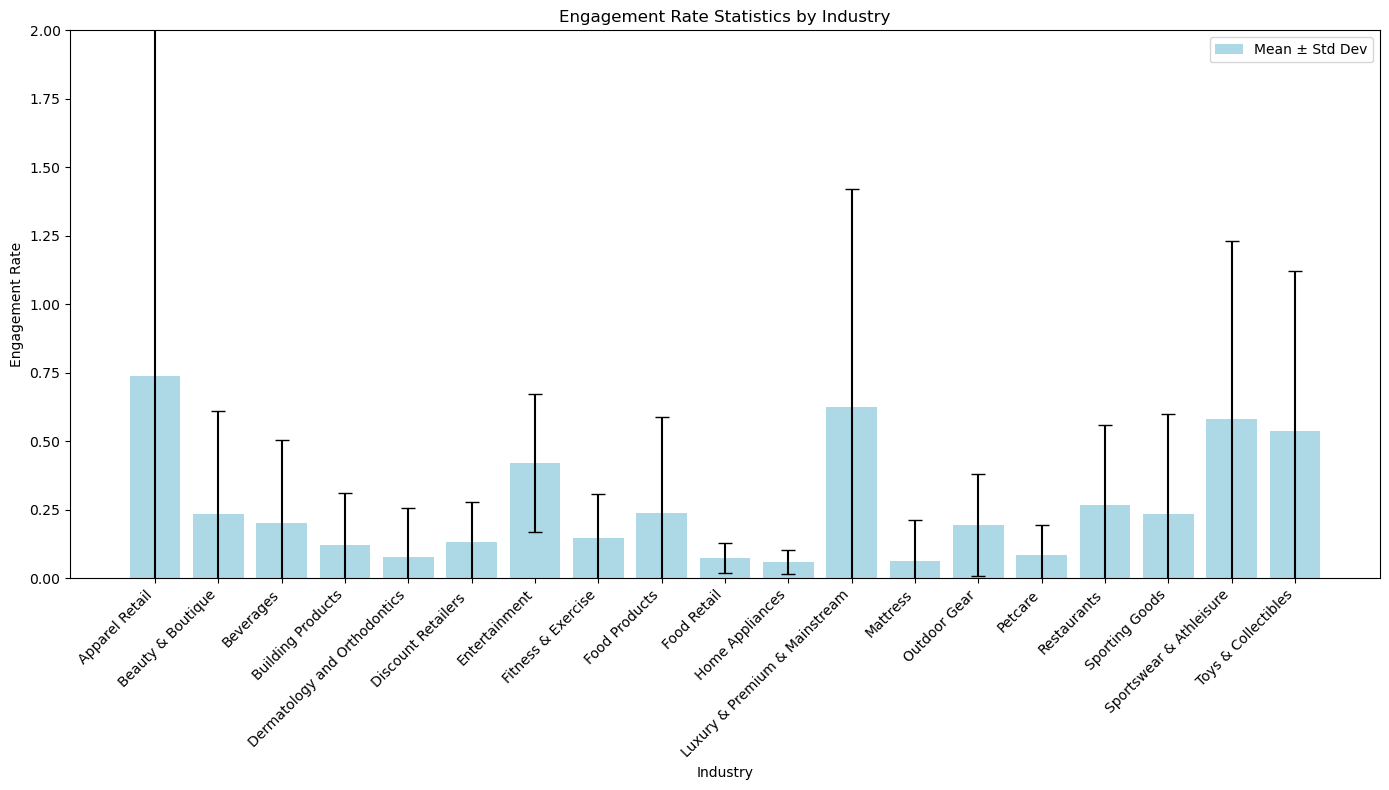

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'industry_engagement_stats' is your DataFrame with 'min' and 'max' columns added
fig, ax = plt.subplots(figsize=(14, 8))

# Create a bar plot for mean engagement rates
ax.bar(industry_engagement_stats['compset_group'], industry_engagement_stats['mean'], yerr=industry_engagement_stats['std'], capsize=5, color='lightblue', label='Mean ± Std Dev')

# Overlay scatter plots for min and max values
# ax.scatter(industry_engagement_stats['compset_group'], industry_engagement_stats['min'], color='green', alpha=0.6, label='Min', zorder=5)
# ax.scatter(industry_engagement_stats['compset_group'], industry_engagement_stats['max'], color='red', alpha=0.6, label='Max', zorder=5)

# Adding labels and title
ax.set_ylim(0,2)
ax.set_xlabel('Industry')
ax.set_ylabel('Engagement Rate')
ax.set_title('Engagement Rate Statistics by Industry')
plt.xticks(rotation=45, ha='right')

# Adding legend to distinguish the plots
ax.legend()

plt.tight_layout()
plt.show()


/var/folders/gd/8zhrd5vs3l9gbslf3h97mk_h0000gn/T/ipykernel_15593/2639430987.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apparel_data['period_end_date'] = pd.to_datetime(apparel_data['period_end_date'])
/var/folders/gd/8zhrd5vs3l9gbslf3h97mk_h0000gn/T/ipykernel_15593/2639430987.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apparel_data['month_year'] = apparel_data['period_end_date'].dt.to_period('M')


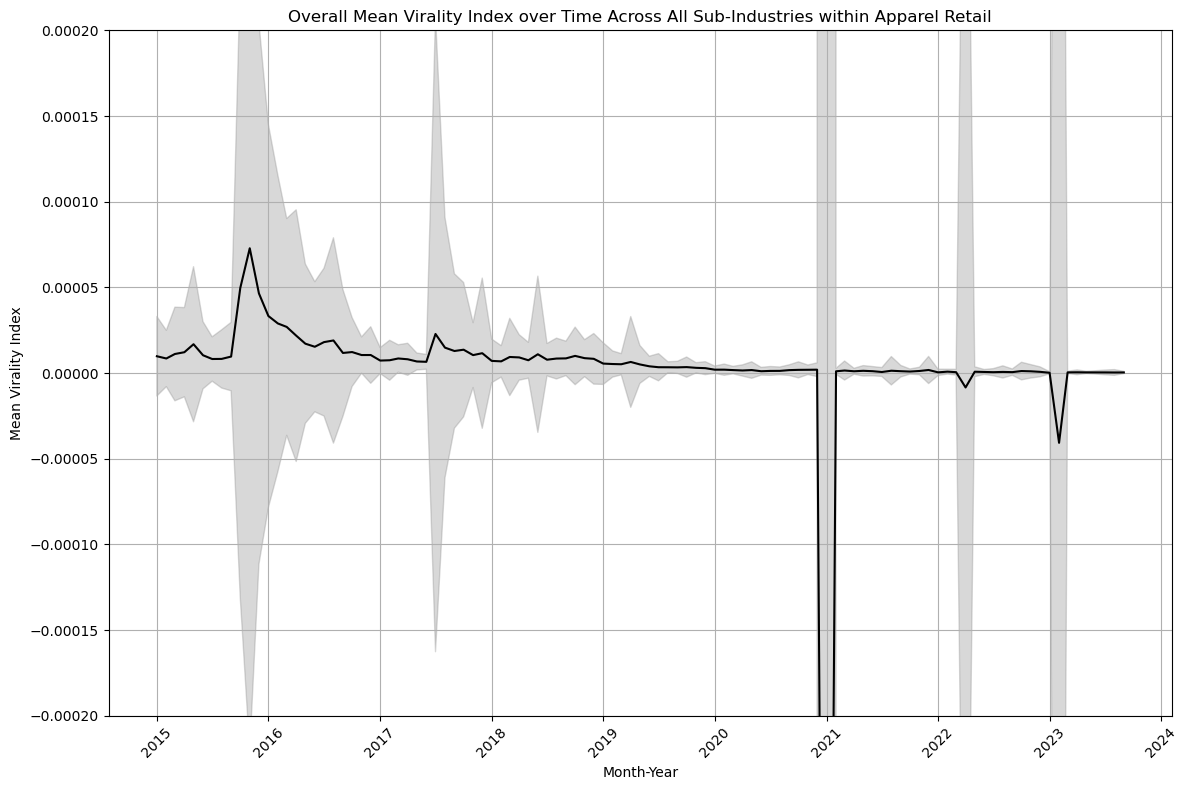

In [79]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define sub-industries within the "Apparel Retail" industry
sub_industries = [
    "Omnichannel Apparel Retail",
    "US Softlines Analyst Interest List",
    "Footwear",
    "US Department Store",
    "Fast Fashion",
    "Apparel Retail",
    "Ecommerce Luxury Apparel Retail",
    "Ecommerce Mainstream Apparel Retail",
    "Mid-Range Watch & Jewelry",
    "Ecommerce Apparel Retail",
    "US Discount Store",
    "Athleisure",
    "Latam Apparel Retail"
]

all_data = pd.concat([df for df in company_tables.values()])

# Assuming 'all_data' is your DataFrame and 'compset' is a column in it
# Explode 'compset' so each element in the list creates a new row
all_data_exploded = all_data.explode('compset')

# Filter data to include only rows where 'compset' is one of the sub-industries
apparel_data = all_data_exploded[all_data_exploded['compset'].isin(sub_industries)]

# Convert 'period_end_date' to datetime if it's not already in datetime format
apparel_data['period_end_date'] = pd.to_datetime(apparel_data['period_end_date'])

# Create a new column 'month_year' that combines the month and year of 'period_end_date'
apparel_data['month_year'] = apparel_data['period_end_date'].dt.to_period('M')

# Group by 'compset' and 'month_year' then calculate the mean and std of virality index
grouped_apparel = apparel_data.groupby(['compset', 'month_year']).agg({'virality_index': ['mean', 'std']}).reset_index()

# Flatten the multi-level column index
grouped_apparel.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in grouped_apparel.columns.values]

# Aggregate to find the mean and std of virality index across all compsets for each month
final_stats_per_month = grouped_apparel.groupby('month_year_').agg({'virality_index_mean': 'mean', 'virality_index_std': 'std'}).reset_index()

# Plotting the overall mean virality index per month with std deviation as shaded area
plt.figure(figsize=(12, 8))
plt.plot(final_stats_per_month['month_year_'].dt.to_timestamp(), final_stats_per_month['virality_index_mean'], marker='', linestyle='-', color='black')
plt.fill_between(final_stats_per_month['month_year_'].dt.to_timestamp(), final_stats_per_month['virality_index_mean'] - final_stats_per_month['virality_index_std'], final_stats_per_month['virality_index_mean'] + final_stats_per_month['virality_index_std'], color='gray', alpha=0.3)
plt.title('Overall Mean Virality Index over Time Across All Sub-Industries within Apparel Retail')
plt.xlabel('Month-Year')
plt.ylabel('Mean Virality Index')
plt.ylim(-2e-4, 2e-4)
plt.xticks(rotation=45)  # Rotates x-axis labels to avoid overlap
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/gd/8zhrd5vs3l9gbslf3h97mk_h0000gn/T/ipykernel_15593/3094320355.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shein_data['month-year'] = pd.to_datetime(shein_data['period_end_date']).dt.to_period('M')


Index(['month-year', 'followers_delta'], dtype='object')


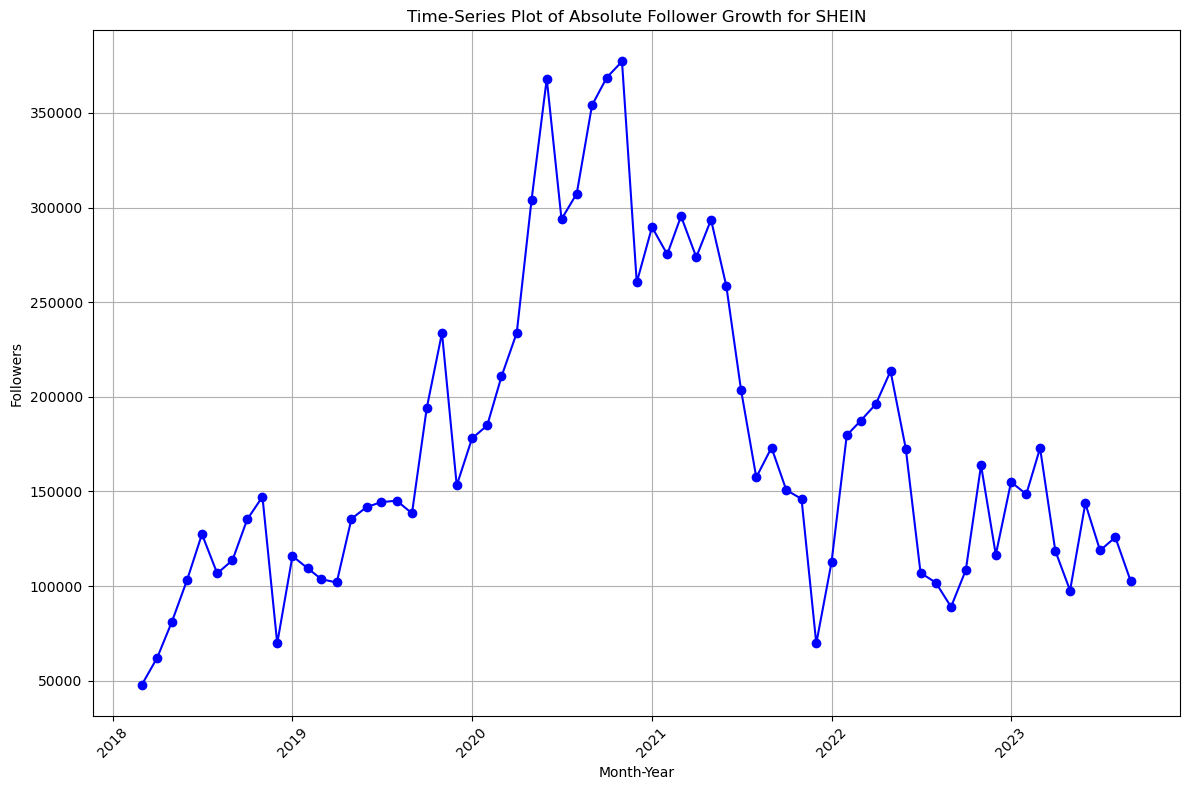

In [101]:
import matplotlib.pyplot as plt

# Variables already defined:
compset_group = 'Retail Apparel'
compset = 'Fast Fashion'
company_name = 'SHEIN'

all_data = pd.concat([df for df in company_tables.values()])
all_data = all_data.explode('compset')

# Assuming all_data is your DataFrame and contains data from multiple companies
# Filter the DataFrame for entries related to SHEIN and the specified compset
shein_data = all_data[(all_data['compset'] == compset) & (all_data['business_entity_doing_business_as_name'] == company_name)]

# Convert 'period_end_date' to datetime format if it's not already
shein_data['month-year'] = pd.to_datetime(shein_data['period_end_date']).dt.to_period('M')

# Group by 'month-year' and calculate the mean relative growth
shein_data_grouped = shein_data.groupby(['month-year']).agg({'followers_delta': 'mean'}).reset_index()

# Sort the DataFrame by 'month-year'
shein_data_sorted = shein_data_grouped.sort_values(by='month-year')

print(shein_data_sorted.columns)

# Plotting the relative growth over time
plt.figure(figsize=(12, 8))
plt.plot(shein_data_sorted['month-year'].dt.to_timestamp(), shein_data_sorted['followers_delta'], marker='o', linestyle='-', color='blue')
plt.title('Time-Series Plot of Absolute Follower Growth for SHEIN')
plt.xlabel('Month-Year')
plt.ylabel('Followers')
plt.grid(True)
plt.xticks(rotation=45)  # Rotates x-axis labels to avoid overlap
plt.tight_layout()
plt.show()